In [1]:
%matplotlib inline
import random, sys, os, pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
from natsort import natsorted
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
print("tensorflow version : ", tf.__version__)

import keras
from keras.models import load_model
from keras.layers import Input
from keras import optimizers
#from keras.metrics import MeanIoU

tensorflow version :  2.3.1


In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [4]:
if IN_COLAB:
    from google.colab import drive
    from tensorflow.python.client import device_lib

    google_drive = '/content/drive'
    drive.mount(google_drive)

    root_dir = google_drive + "/MyDrive/cs-433-project-2-team-afm"
    sys.path.append(root_dir)
    
    # Make sure that the graphics card appears in the device list
    # If this is not the case in google colab, then change the runtime type to GPU    
    npt.assert_('GPU' in str(device_lib.list_local_devices()))
else:
    root_dir = "."

In [5]:
from src.utils.image_utils import load_images, img_float_to_uint8, concatenate_images, make_img_overlay, predict
from src.utils.mask_to_submission import mask_to_submission_strings, masks_to_submission_enum
from src.utils.preprocessing import normalize_data, normalize_data_with_given_mean_and_std, data_augmentation
from src.utils.neural_network import convolutional_model
%load_ext autoreload
%autoreload 2 # auto-reload all the modules

In [6]:
train_model = True #when equal to false, reload previously saved model
normalize = False

# Set environment

In [7]:
#if IN_COLAB:
#    os.environ['TF_CUDNN_DETERMINISTIC'] = '1#'TensorFlow cuDNN auto-tuning

In [8]:
#Set seeds
SEED = 1
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
tf.keras.backend.set_floatx('float32')

## Load images

In [10]:
train_dir = root_dir + '/data/training/'

train_files, imgs = load_images(train_dir + "images/")
gt_files, gt_imgs = load_images(train_dir + "groundtruth/")
_, unlabel_imgs = load_images(root_dir + '/data/test_set_images/')

# Ensure that train and mask files have the same names
npt.assert_equal(natsorted(train_files), natsorted(gt_files))

Loading 100 images
Loading 100 images
Loading 50 images


In [11]:
TRAIN_SAMPLES = len(imgs)
IMAGE_HEIGHT = imgs[0].shape[0]
IMAGE_WIDTH = imgs[0].shape[1]
CROPPED_WIDTH = 400
NUM_CHANNELS = imgs[0].shape[2]
print('Images length = ' + str(TRAIN_SAMPLES) + ', masks lengths: ' + str(len(gt_imgs)))
print('Image size = ' + str(IMAGE_HEIGHT) + ',' + str(IMAGE_WIDTH) + ',' + str(NUM_CHANNELS) )
print('GT shape size = ' + str(len(gt_imgs[0].shape) ))

Images length = 100, masks lengths: 100
Image size = 400,400,3
GT shape size = 2


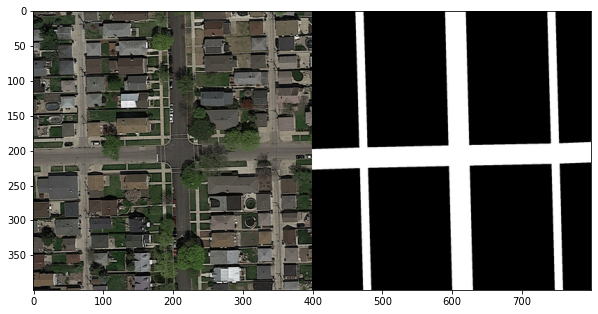

In [12]:
# Show first image and its groundtruth image
for i in range(0,1):
  cimg = concatenate_images(imgs[i], gt_imgs[i])
  fig1 = plt.figure(figsize=(10, 10))
  plt.imshow(cimg, cmap='Greys_r');

In [13]:
imgs = np.array(imgs)
gt_imgs = np.reshape(np.array(gt_imgs), (TRAIN_SAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH, 1));
unlabel_imgs = np.array(unlabel_imgs)
print(imgs.shape)
print(gt_imgs.shape)
print(unlabel_imgs.shape)

(100, 400, 400, 3)
(100, 400, 400, 1)
(50, 608, 608, 3)


## Do train/test split

In [14]:
train_images, test_images, train_masks, test_masks = train_test_split(imgs, gt_imgs, test_size=0.2, random_state=SEED)

print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(80, 400, 400, 3)
(80, 400, 400, 1)
TEST SET
(20, 400, 400, 3)
(20, 400, 400, 1)


## Normalize

In [15]:

if normalize ==  True:
  # Normalize data
  norm_train_images, _, std_data  = normalize_data(train_images, mean_zero = True)
  norm_test_images = normalize_data_with_given_mean_and_std(test_images, 0, std_data)
  norm_unlabel_images = normalize_data_with_given_mean_and_std(unlabel_imgs, 0, std_data)
  #norm_unlabel_images, _, _ = normalize_data(unlabel_imgs)
else:
  norm_train_images = train_images
  norm_test_images = test_images
  norm_unlabel_images = unlabel_imgs

## Input augmentation

In [16]:
# Provide the same seed
image_generator = data_augmentation(norm_test_images, seed=SEED)
mask_generator = data_augmentation(test_masks, seed=SEED)

In [17]:
def crop_center(img, crop_size):
    # Note: image_data_format is 'channel_last'
    #assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = crop_size
    x = int((width - dx) / 2)
    y = int((height - dy) / 2)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch = next(batches)
        batch_crops = np.zeros((batch.shape[0], crop_length, crop_length, 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = crop_center(batch[i], (crop_length, crop_length))
        yield batch_crops


In [26]:
image_generator = crop_generator(image_generator, CROPPED_WIDTH)
mask_generator = crop_generator(mask_generator, CROPPED_WIDTH)

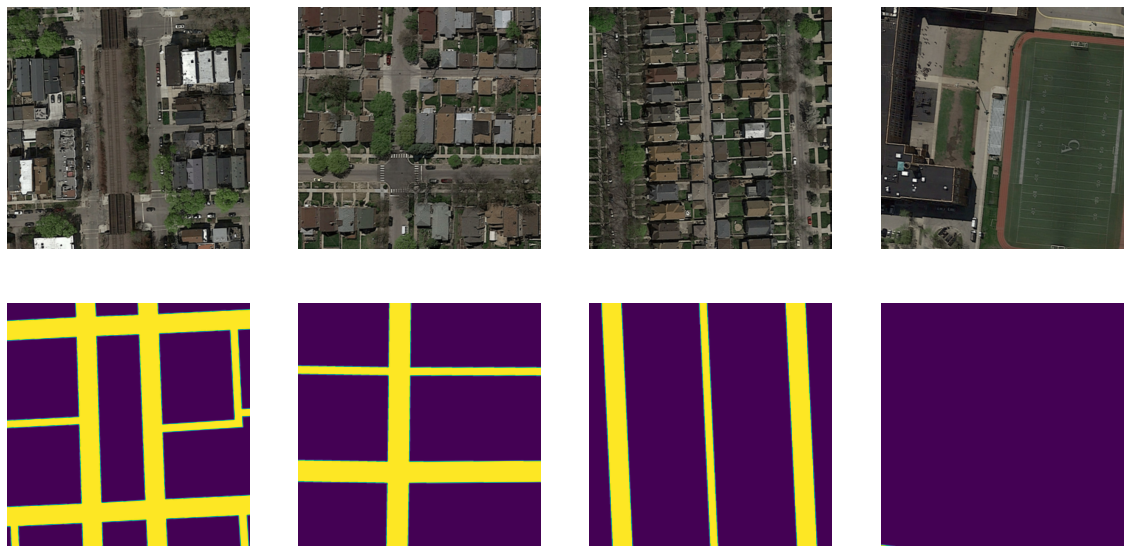

In [19]:
# generate samples and plot
rows = 1 
ncols = 4
fig, ax = plt.subplots(nrows=2*rows, ncols=ncols, figsize=(20,10))

for r in range(0,rows):
  for i in range(0,ncols):
      image_train = next(image_generator)[0];
      image_mask = np.squeeze(next(mask_generator)[0]);
  
      # plot image
      row_im = 2*r;
      row_mask = row_im + 1;
      ax[row_im,i].imshow(image_train);
      ax[row_im,i].axis('off');
      ax[row_mask,i].imshow(image_mask);
      ax[row_mask,i].axis('off');

# U-net for predictions

## Define the model

In [21]:
inputs = Input((CROPPED_WIDTH, CROPPED_WIDTH, NUM_CHANNELS))
model = convolutional_model(inputs, normalize=False)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 400, 400, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [22]:
norm_train_images.shape

(80, 400, 400, 3)

In [23]:
EPOCHS = 20
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [24]:
opt = keras.optimizers.Adam(LEARNING_RATE)
bce = tf.keras.losses.BinaryCrossentropy()
model.compile(
      optimizer=opt,
      loss=bce,
      metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

## Train the model

In [25]:
if train_model == True:
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  history = model.fit(zip(image_generator, mask_generator),
                    epochs=EPOCHS,
                    steps_per_epoch=100,
                    #validation_data=(norm_test_images, test_masks),
                    batch_size = BATCH_SIZE
                    #, callbacks=[callback]
                    )

Epoch 1/20
  1/100 [..............................] - ETA: 0s - loss: 0.8393 - precision: 0.2857 - recall: 0.5253

KeyboardInterrupt: 

## Save model and history

In [ ]:
model_name = "test_model"
result_dir = root_dir + "/results/"

if not os.path.exists(result_dir):
  os.makedirs(result_dir)

model_name_ext = model_name + ".h5"

In [ ]:
if train_model == True:
  model.save(result_dir + model_name_ext)
  pickle.dump(history.history, open(result_dir + model_name + "_history.p", "wb"))

## Load model

In [ ]:
model = load_model(result_dir + model_name_ext)

## Evaluate model for test images

In [ ]:
model.evaluate(norm_test_images, test_masks)

In [ ]:
predictions = model.predict(norm_test_images, verbose=1);
predictions_train = model.predict(norm_train_images);

In [ ]:
cimg = np.squeeze(concatenate_images(predictions[0], test_masks[0]))
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)

In [ ]:
fig1 = plt.figure(figsize=(10, 10)) 
plt.imshow(cimg, cmap='Greys_r')
new_img = make_img_overlay(test_images[1], np.squeeze(predictions[1]))
plt.imshow(new_img);

## Do predictions for the unlabeled data

In [ ]:
predictions = []
for test_image in unlabel_imgs:
    predictions.append(predict(test_image, model, IMAGE_HEIGHT, IMAGE_WIDTH));
predictions = np.array(predictions)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,40))

index = 10
ax[0].imshow(unlabel_imgs[10]);
ax[1].imshow(predictions[10]);
print(predictions[10].shape)

In [ ]:
fig1 = plt.figure(figsize=(10, 10)) 
plt.imshow(cimg, cmap='Greys_r')
new_img = make_img_overlay(unlabel_imgs[1], np.squeeze(predictions[1]))
plt.imshow(new_img);

In [ ]:
submission_filename = result_dir + model_name + '_submission.csv'
masks_to_submission_enum(submission_filename, *predictions)